# Персонализированные предложения для интернет-магазина "В один клик"

Отчёт интернет-магазина «В один клик» за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. Нам предстоит разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Первым шагом загрузим данные: 4 датафрейма с данными о поведении покупателей, об общей выручке с покупателя, о проведённом времени покупателем на сайте, о среднемесячной выручке с покупателя за 3 последних месяца. Далее проведём предобработку данных. Следующим шагом проведём исследовательский анализ данных. Затем объединим 3 датафрейма (без среднемесячной выручки). После этого проведём корреляционный анализ, чтобы устранить, если имеется, мультиколинеарность. Потом создадим пайплайн, чтобы найти лучшую модель. Далее выполним анализ важности признаков. Затем проведём сегментацию покупателей, чтобы лучше описать отдельную группу покупателей. В конце сделаем вывод.

<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Использование-пайплайнов" data-toc-modified-id="Использование-пайплайнов-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Использование пайплайнов</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Сегментация-покупателей" data-toc-modified-id="Сегментация-покупателей-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Сегментация покупателей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

Для более удобного перемещения по проекту сделали оглавление.

## Загрузка данных

In [1]:
!pip install phik -q
!pip install matplotlib==3.5.1 -q
!pip install scikit-learn --upgrade -q
!pip install shap -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import phik
import shap

In [3]:
market = pd.read_csv('./market_file.csv')
total_money = pd.read_csv('./market_money.csv')
time = pd.read_csv('./market_time.csv')
avg_money = pd.read_csv('./money.csv', delimiter=';', decimal=',')

In [4]:
market.info()
market.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
total_money.info()
total_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
time.info()
time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
avg_money.info()
avg_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Загрузили все 4 датафрейма. Все данные соответствуют описанию.**

## Предобработка данных

Переименуем столбцы в датафреймах

In [8]:
market.columns = ['id', 'активность', 'тип_сервиса', 'разрешение_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
                 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
total_money.columns = ['id', 'период', 'выручка']
time.columns = ['id', 'период', 'минуты']
avg_money.columns = ['id', 'прибыль']

Проведём предобработку данных, а именно исправим названия некоторых категориальных значений, проверим на дубликаты.

Так, мы видим, что в датафрейме market в столбце "тип сервиса" значение "стандарт" написан как "стандартт", так же есть похожие ошибки в других датафреймах, исправим это. А заодно проверим все категориальные значения.

In [9]:
cat_col_market = ['активность', 'тип_сервиса', 'разрешение_сообщать', 'популярная_категория']
for i in cat_col_market:
    print(i, market[i].unique())

активность ['Снизилась' 'Прежний уровень']
тип_сервиса ['премиум' 'стандартт' 'стандарт']
разрешение_сообщать ['да' 'нет']
популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [10]:
print(total_money['период'].unique())
print(time['период'].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']


Заменим в дф маркет в столбце Тип сервиса "стандартт" на "стандарт", а так же исправим в датафрейме тайм "предыдущий_месяц" в столбце период на "предыдущий_месяц"

In [11]:
market.loc[market['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
time.loc[time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
print(market['тип_сервиса'].unique())
print(time['период'].unique())

['премиум' 'стандарт']
['текущий_месяц' 'предыдущий_месяц']


In [12]:
market.duplicated().sum()

0

In [13]:
total_money.duplicated().sum()

0

In [14]:
time.duplicated().sum()

0

In [15]:
avg_money.duplicated().sum()

0

Видим, что дубликатов нет. Но мы преобразовали некоторые значения категориальных признаков. Пропусков в данных нет. Кроме того, типы столбцов тоже соответствуют.

## Исследовательский анализ данных

Прежний уровень    0.616923
Снизилась          0.383077
Name: активность, dtype: float64


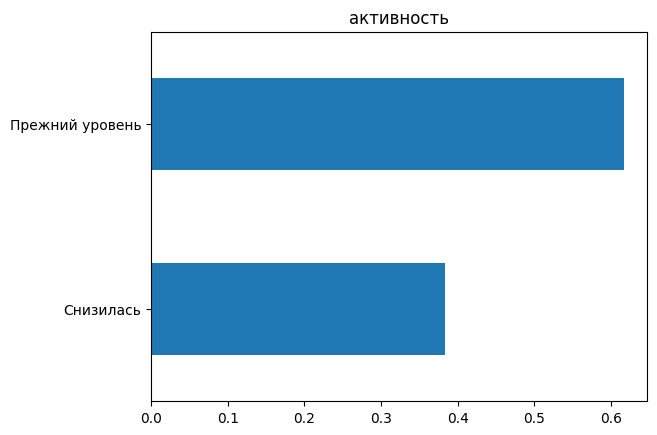

стандарт    0.710769
премиум     0.289231
Name: тип_сервиса, dtype: float64


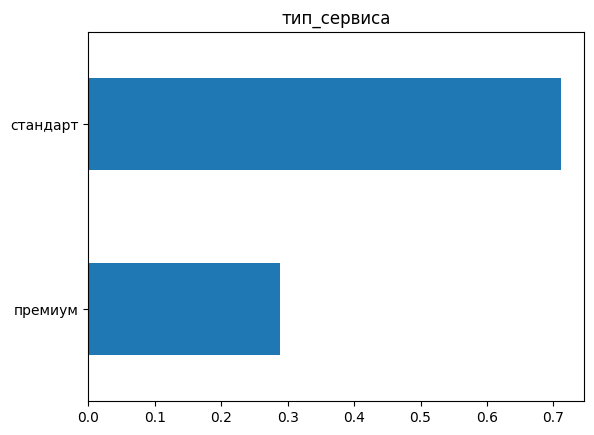

да     0.74
нет    0.26
Name: разрешение_сообщать, dtype: float64


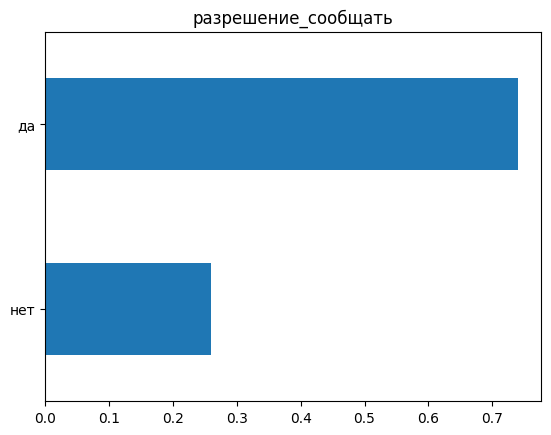

Товары для детей                        0.253846
Домашний текстиль                       0.193077
Косметика и аксесуары                   0.171538
Техника для красоты и здоровья          0.141538
Мелкая бытовая техника и электроника    0.133846
Кухонная посуда                         0.106154
Name: популярная_категория, dtype: float64


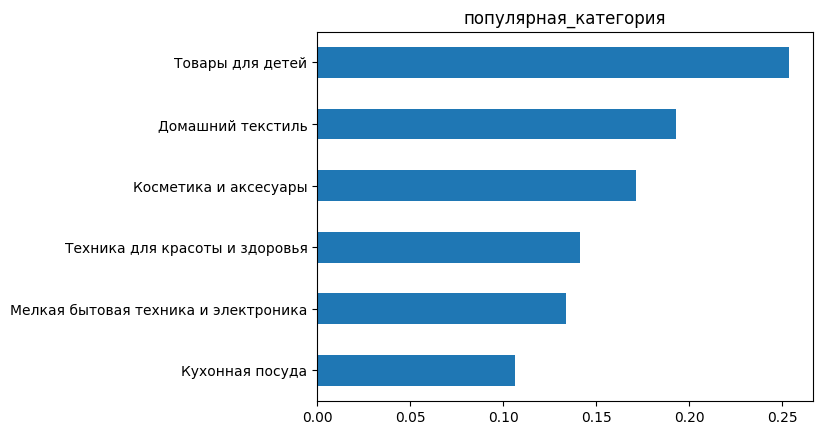

In [16]:
for i in cat_col_market:
    print(market[i].value_counts(normalize=True, ascending=False))
    market[i].value_counts(normalize=True, ascending=True).plot(kind='barh')
    plt.title(i)
    plt.show();

Видим, чтоо у 71% уровень стандартный пользовательский уровень. Кроме того 74% пользователей разрешили присылать предложения о новых товарах. Самая популярная категория у пользователей - Товары для детей.

Создадим список столбцов с числовыми значениями у датафрейма маркет, а затем выведем гистограммы для количественных признаков.

In [17]:
num_col_market = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
                  'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
                 'ошибка_сервиса', 'страниц_за_визит']

маркет_актив_6_мес 
 count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


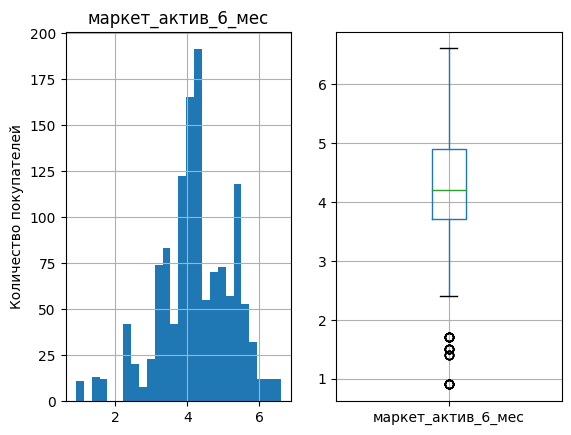

маркет_актив_тек_мес 
 count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


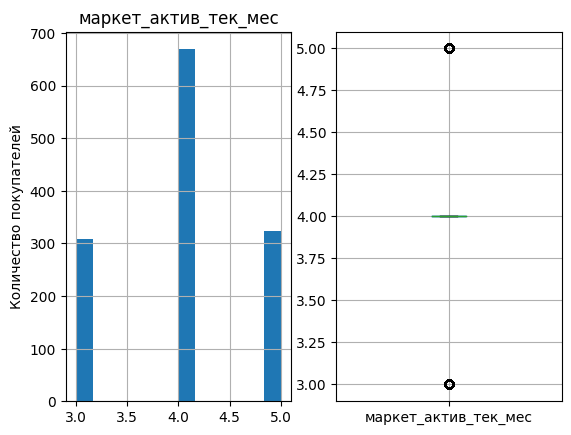

длительность 
 count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


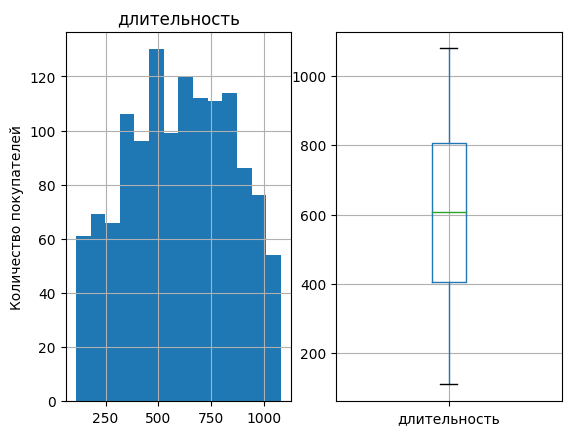

акционные_покупки 
 count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


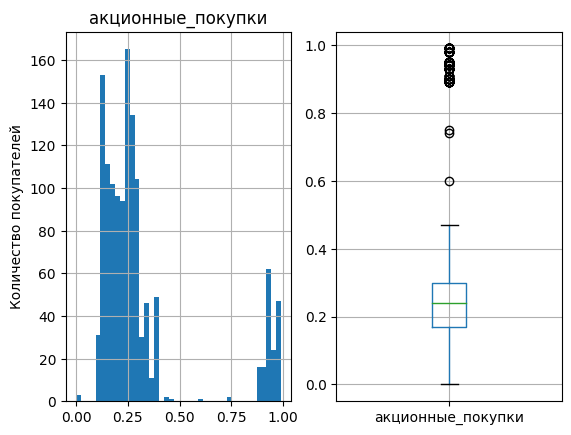

средний_просмотр_категорий_за_визит 
 count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


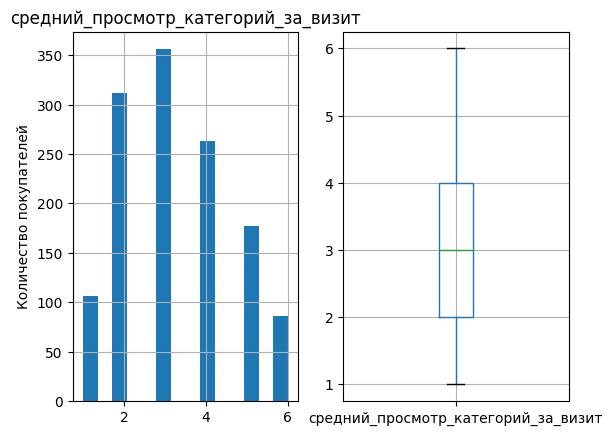

неоплаченные_продукты_штук_квартал 
 count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


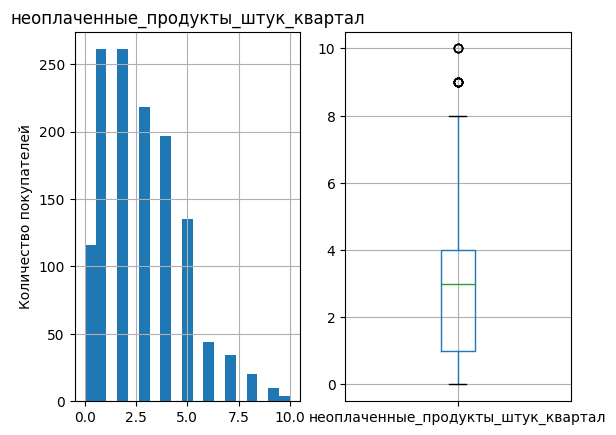

ошибка_сервиса 
 count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


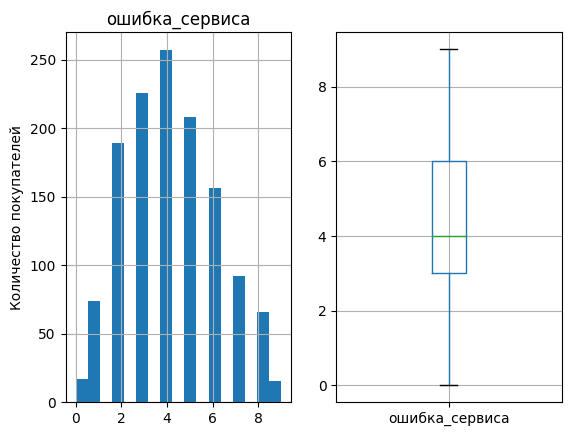

страниц_за_визит 
 count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


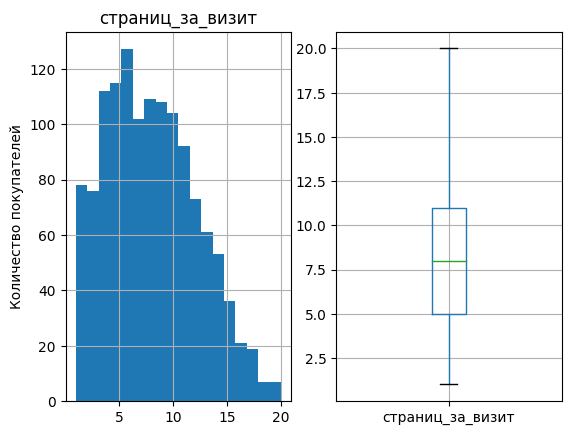

In [18]:
for i in num_col_market:
    print(i, '\n', market[i].describe())
    plt.subplot(121)
    market[i].hist(bins='auto')
    plt.ylabel('Количество покупателей')
    plt.title(i)
    plt.subplot(122)
    market.boxplot(i)
    plt.show();

Видим, что есть целая группа покупателей, у которых 90% и более товаров - акционные. Интересно, что на некоторых покупателей в среднем за месяц приходилось более 6 взаимодействий, а на других покупателей менее 1.

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

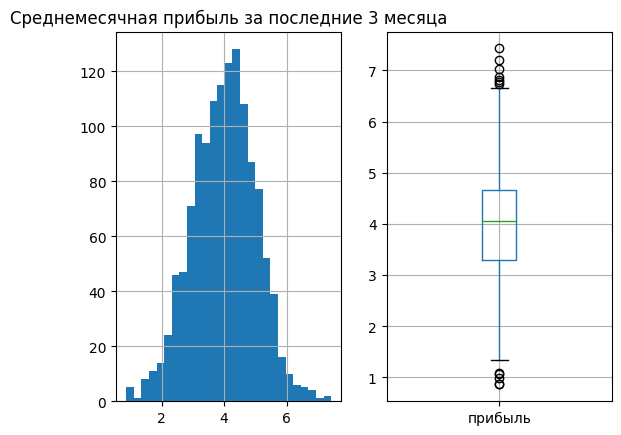

In [19]:
plt.subplot(121)
avg_money['прибыль'].hist(bins='auto')
plt.title('Среднемесячная прибыль за последние 3 месяца')
plt.subplot(122)
avg_money.boxplot('прибыль')
plt.show;
avg_money['прибыль'].describe()

Почти нормальное распределение с медианой в 4.

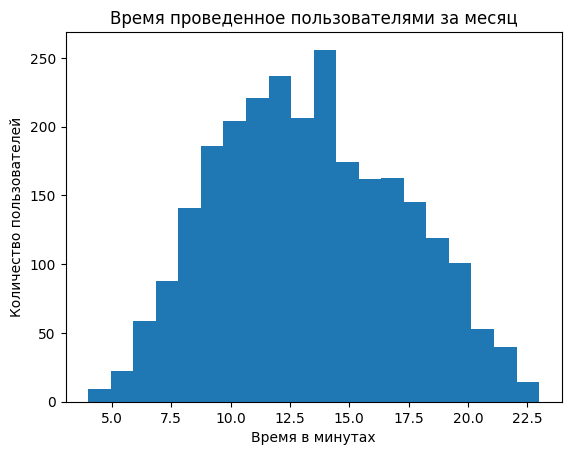

In [20]:
plt.hist(time['минуты'], bins=20);
plt.title('Время проведенное пользователями за месяц')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.show()

Построили гистограмму для минут, которые пользователь провёл на сайте за месяц. Но что интересно, что эти минуты разбиты на прошлый месяц и текущий, поэтому выведем графики раздельно для каждого месяца.

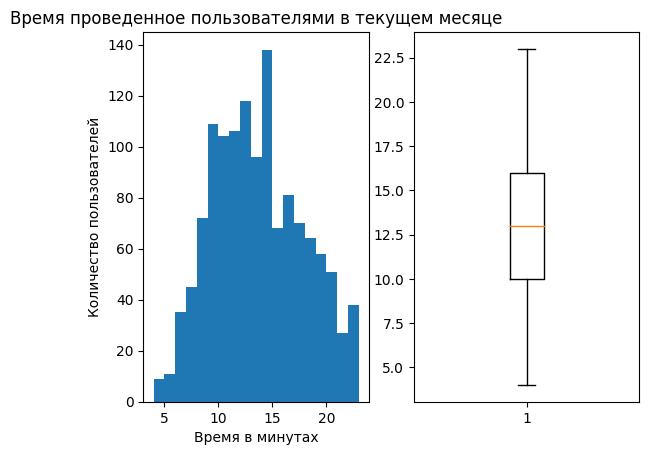

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минуты, dtype: float64

In [21]:
plt.subplot(121)
plt.hist(bins=19, x=time.loc[time['период']=='текущий_месяц', 'минуты'])
plt.title('Время проведенное пользователями в текущем месяце')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.subplot(122)
plt.boxplot(time.loc[time['период']=='текущий_месяц', 'минуты'])
plt.show()
time.loc[time['период']=='текущий_месяц', 'минуты'].describe()

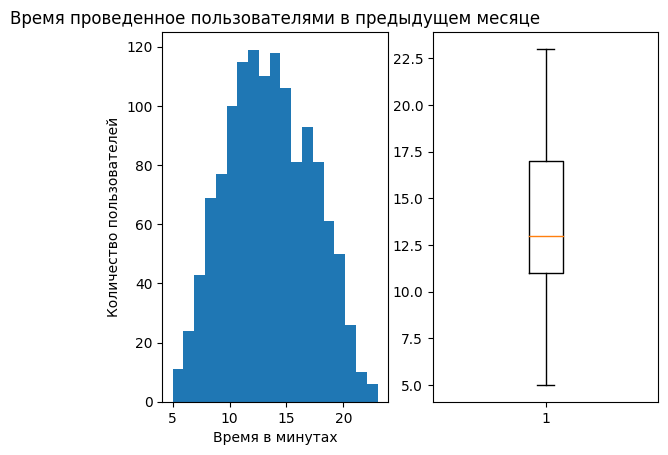

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: минуты, dtype: float64

In [22]:
plt.subplot(121)
plt.hist(bins=19, x=time.loc[time['период']=='предыдущий_месяц', 'минуты'])
plt.title('Время проведенное пользователями в предыдущем месяце')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.subplot(122)
plt.boxplot(time.loc[time['период']=='предыдущий_месяц', 'минуты'])
plt.show()
time.loc[time['период']=='предыдущий_месяц', 'минуты'].describe()

Видим, что график проведённого времени на сайте поменялся немного, так в предыдущем месяце график выглядит как нормальное распределение. Но что примечательно, среднее значение практически не поменялось, а медиана и вовсе осталась такой же.

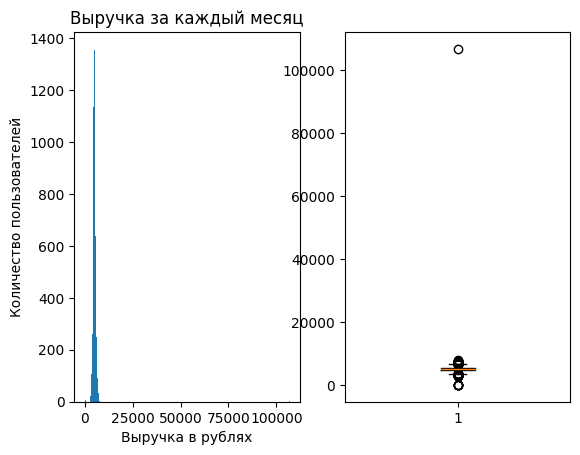

In [23]:
plt.subplot(121)
total_money['выручка'].plot(kind='hist', bins=200)
plt.title('Выручка за каждый месяц')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество пользователей')
plt.subplot(122)
plt.boxplot(total_money['выручка'])
plt.show;

Это гистограмма выручки помесячная. Выведем график для суммарной выручки каждого пользователя за 3 месяца.

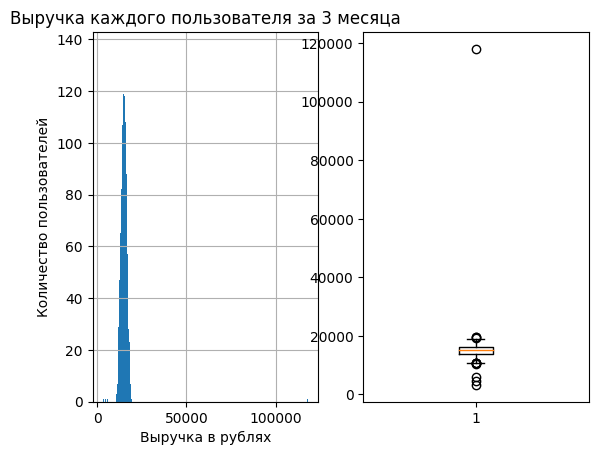

count      1300.000000
mean      15077.088154
std        3301.835476
min        3293.100000
25%       13942.950000
50%       15071.500000
75%       16087.025000
max      117990.200000
Name: выручка, dtype: float64

In [24]:
n = pd.DataFrame(total_money.groupby('id')['выручка'].sum().reset_index())
plt.subplot(121)
n['выручка'].hist(bins='auto')
plt.title('Выручка каждого пользователя за 3 месяца')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество пользователей')
plt.subplot(122)
plt.boxplot(n['выручка'])
plt.show()
n['выручка'].describe()

Есть пользователь, который принес выручки почти 120 тысяч рублей. Но медиана на уровне 15 тысяч за 3 месяца. Удалим данный выброс, так как исказит модель и анализ.

In [25]:
peak = total_money.loc[total_money['выручка'] > 50000]

In [26]:
peak

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [27]:
market = market.loc[~market['id'].isin(peak['id'])]

In [28]:
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   активность                           1299 non-null   object 
 2   тип_сервиса                          1299 non-null   object 
 3   разрешение_сообщать                  1299 non-null   object 
 4   маркет_актив_6_мес                   1299 non-null   float64
 5   маркет_актив_тек_мес                 1299 non-null   int64  
 6   длительность                         1299 non-null   int64  
 7   акционные_покупки                    1299 non-null   float64
 8   популярная_категория                 1299 non-null   object 
 9   средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  ошибка_сервиса                

Удалили выброс, убрав пользователя по айди в главном датасете.

Итак, все пользователи приносили ту или иную выручку за 3 последних месяца. Большое количество людей оставляют товары в корзине (от 1 до 4 товаров), при этом есть относительно большая группа людей, которые покупают по акциям товаров почти на 80-100% от всех купленных товаров. Кроме того, почти нет пользователей, которые вообще не покупают по акциям. Но при этом не равномерно присылаются акционные предложения, хотя почти 80% пользователей дали разрешение на получение акционных предложений.

## Объединение таблиц

In [29]:
total_money_conv = total_money.pivot(columns = 'период', values = 'выручка', index='id').reset_index()
total_money_conv = total_money_conv.reindex(columns=['id', 'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц'])
total_money_conv.columns = ['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']
total_money_conv

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4
3,215351,4793.0,6158.0,6610.4
4,215352,4594.0,5807.5,5872.5
...,...,...,...,...
1295,216643,4704.0,3664.0,4741.7
1296,216644,5299.0,4729.0,5353.0
1297,216645,5334.0,5160.0,5139.2
1298,216646,4725.0,4923.0,5224.6


In [30]:
time_conv = time.pivot(columns = 'период', values = 'минуты', index='id').reset_index()
time_conv.columns = ['id', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']
time_conv

,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


Преобразовали датафреймы для того, чтобы далее объединить датафреймы.

In [31]:
market_new = market.merge(time_conv, on='id', how='left')
market_new = market_new.merge(total_money_conv, on='id', how='left')
market_new.info()
display(market_new.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   активность                           1299 non-null   object 
 2   тип_сервиса                          1299 non-null   object 
 3   разрешение_сообщать                  1299 non-null   object 
 4   маркет_актив_6_мес                   1299 non-null   float64
 5   маркет_актив_тек_мес                 1299 non-null   int64  
 6   длительность                         1299 non-null   int64  
 7   акционные_покупки                    1299 non-null   float64
 8   популярная_категория                 1299 non-null   object 
 9   средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  ошибка_сервиса                

,id,активность,тип_сервиса,разрешение_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,13,14,0.0,0.0,3293.1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,5216.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5457.5,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6158.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5807.5,5872.5


Объединили 3 датафрейма.

In [32]:
market_new = market_new.loc[(market_new['выручка_препредыдущий_месяц'] != 0)]
market_new = market_new.loc[(market_new['выручка_предыдущий_месяц'] != 0)]
market_new = market_new.loc[(market_new['выручка_текущий_месяц'] != 0)]

In [33]:
market_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1298
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   активность                           1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешение_сообщать                  1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

Уберём клиентов, которые хотя бы в одном месяце ничего не покупали.

## Корреляционный анализ

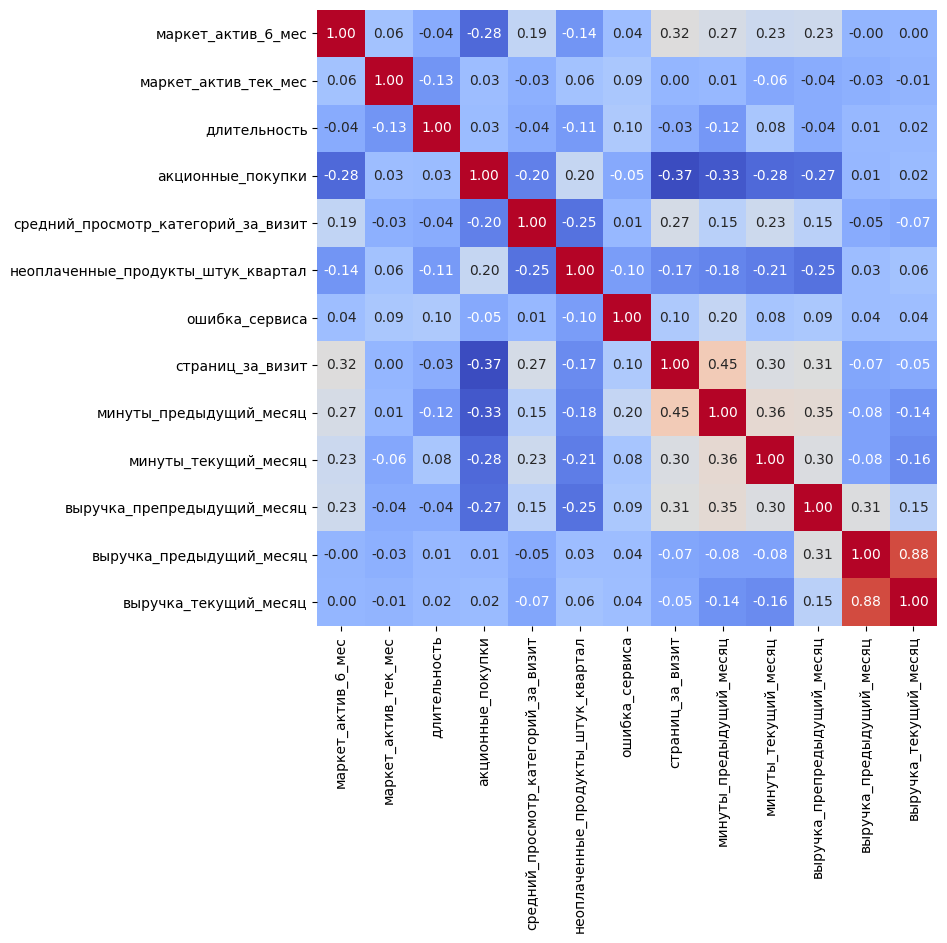

In [35]:
plt.figure(figsize=(8, 8))
sns.heatmap(market_new.drop(columns='id').corr('spearman'), annot=True, fmt='.2f', cbar=False, cmap='coolwarm')
plt.show();

*Применили распределение Спирмена вместо Пирсона, так как коэффициент Пирсона чувствителен к выбросам и не применяется при не нормальной распределения данных. Исходя из матрицы, можно сказать, что в данных крайне высокая корреляция между выручкой в предыдущем месяце и текущем равная 0.88. Но этого недостаточно чтобы говорить о мультиколлинеарности, которую можно определить при корреляции равной 0.9 и выше.*

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']


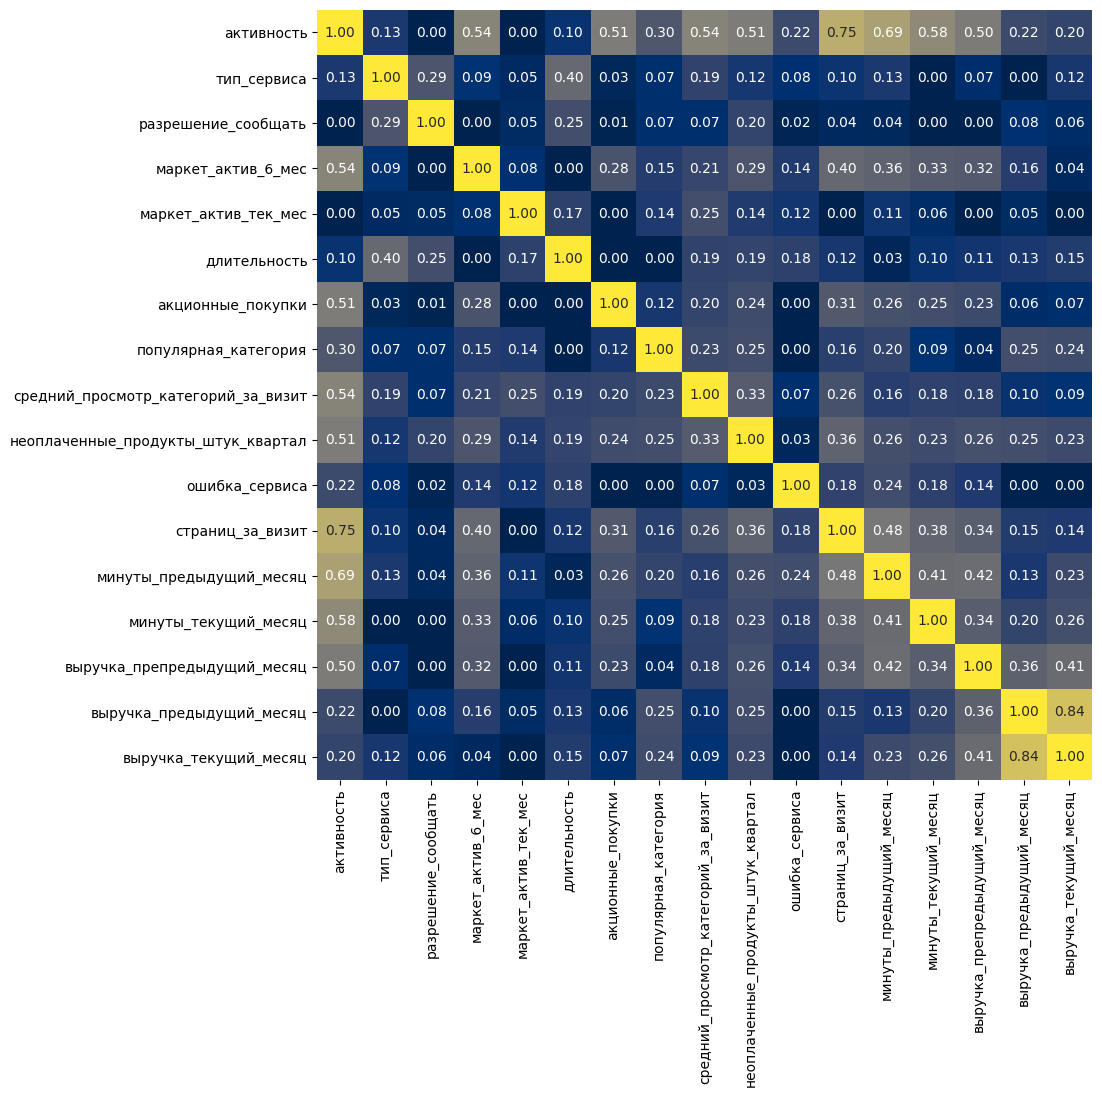

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(market_new.drop(columns='id').phik_matrix(), annot=True, cmap='cividis', fmt='.2f', cbar=False)
plt.show();

По обоим таблицам корреляции у нас в данных нет мультиколлинеарности. Хотя между выручками довольно высокая корреляция.

## Использование пайплайнов

In [37]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [38]:
# разбиваем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_new.drop(['id', 'активность'], axis=1),
    market_new['активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_new['активность'])

**Закодируем целевой признак**

In [39]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test) 

In [40]:
print(label_encoder.classes_) 

['Прежний уровень' 'Снизилась']


Закодировали "снизилась" как единицу

In [41]:
X_train.shape, X_test.shape
# создаём списки с названиями признаков
ohe_columns = ['разрешение_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
       'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

In [42]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [43]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE + SimpleImputer
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [44]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [45]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

In [46]:
# зададим гиперпараметры и методы масштабирования для каждой модели:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, 
            solver='saga', penalty='l1', max_iter=10000)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf', 'sigmoid'],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
]

In [47]:
# запустим перебор моделей, гиперпараметров и методов масштабирования
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE,
    n_jobs = -1,
    n_iter = 20
)

In [48]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешение_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeli...
                                                                       random_state=42,
                                                                       solver='saga')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': [0.01, 0.1, 1, 10, 100],
                                         'models__kernel': ['linear', 'rbf',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [49]:
best_model = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешение_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                

In [50]:
y_test_pred = best_model.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9209642842697084


In [51]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
12,1,"SVC(probability=True, random_state=42)",0.900786,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'rbf', 'models__C': 0.1, 'models': SVC(probability=True, random_state=42)}"
10,2,"LogisticRegression(max_iter=10000, penalty='l1', random_state=42, solver='saga')",0.896621,"{'preprocessor__num': MinMaxScaler(), 'models__C': 5, 'models': LogisticRegression(max_iter=10000, penalty='l1', random_state=42, solver='saga')}"
14,3,"LogisticRegression(max_iter=10000, penalty='l1', random_state=42, solver='saga')",0.896575,"{'preprocessor__num': MinMaxScaler(), 'models__C': 6, 'models': LogisticRegression(max_iter=10000, penalty='l1', random_state=42, solver='saga')}"
13,4,"LogisticRegression(max_iter=10000, penalty='l1', random_state=42, solver='saga')",0.895925,"{'preprocessor__num': StandardScaler(), 'models__C': 2, 'models': LogisticRegression(max_iter=10000, penalty='l1', random_state=42, solver='saga')}"
1,5,KNeighborsClassifier(),0.893807,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 11, 'models': KNeighborsClassifier()}"
9,6,"SVC(probability=True, random_state=42)",0.892273,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'linear', 'models__C': 10, 'models': SVC(probability=True, random_state=42)}"
11,7,"SVC(probability=True, random_state=42)",0.887937,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'rbf', 'models__C': 10, 'models': SVC(probability=True, random_state=42)}"
4,8,"SVC(probability=True, random_state=42)",0.880110,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'sigmoid', 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"
3,9,KNeighborsClassifier(),0.856646,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 21, 'models': KNeighborsClassifier()}"
18,10,DecisionTreeClassifier(random_state=42),0.826410,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"


Выбрали ROC_AUC в качестве метрики, так как нам без разницы какая ошибка будет 1 или 2 рода. Нам важна точность в независимости от порога. Но более того, у нас стоит задача бинарной классификации и присутствует дисбаланс классов, поэтому ROC_AUC использовали. Кроме того, мы определили лучшую модель - это метод опорных векторов при ядре rbf. Что интересно, roc-auc на тестовой выборке составил 0,92. Что является достаточно высоким показателем. Поиск лучшей модели провели с сипользованием пайплайнов, таким образом SVC стала лучше чем kNN, линейная регрессия и дерево решений.

## Анализ важности признаков

In [52]:
X = randomized_search.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
k = shap.sample(X, 50)
explainer = shap.KernelExplainer(randomized_search.best_estimator_['models'].predict_proba, k)
shap_values = explainer(X[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

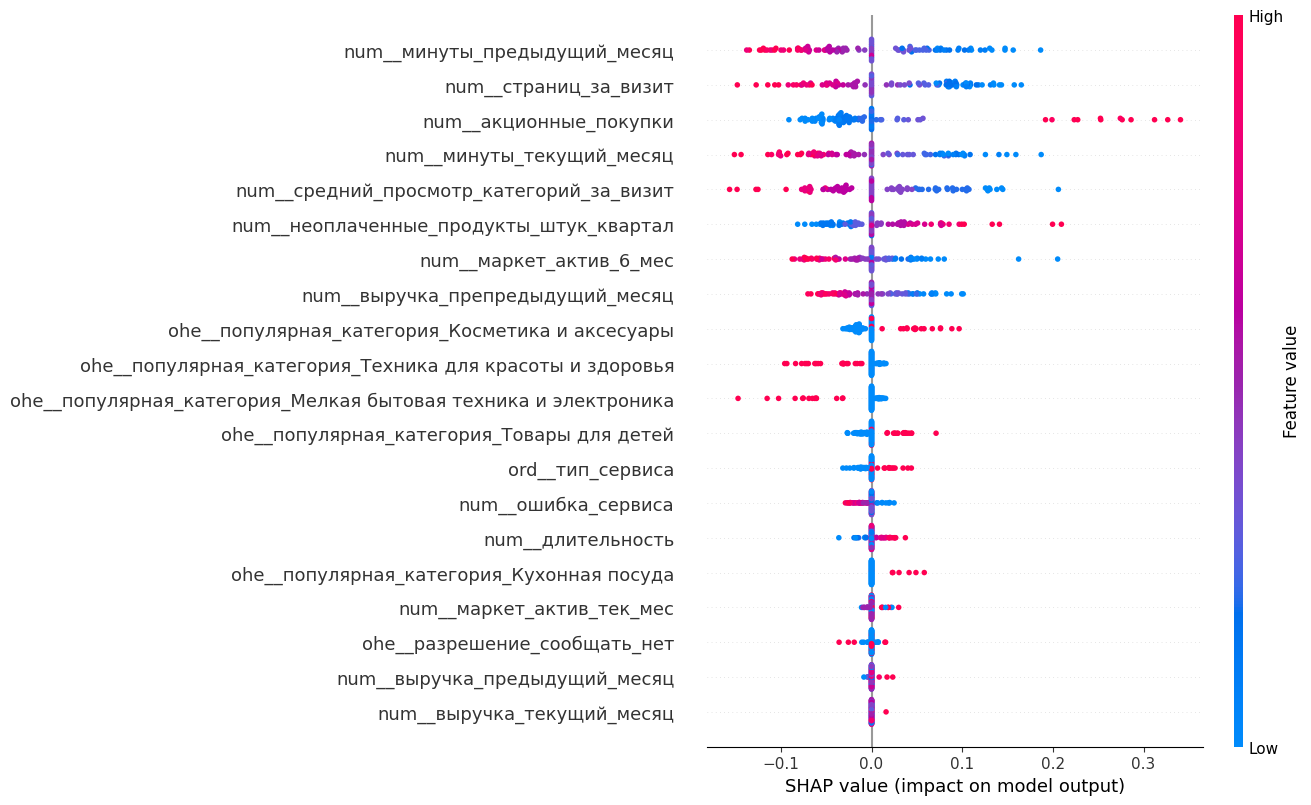

In [53]:
shap.plots.beeswarm(shap_values[..., 1], max_display=20)

Итак, мы построили график важности SHAP. Видим, что исходя из этого графика, больше всего влияют на то, останется прежним уровень активности или упадёт, следующие признаки (4 из 6 "топовых" признака): страницы за визит, средний просмотр категорий за визит, минуты в текущем месяце, минуты в предыдущем месяце. Что интересно, с уменьшением значений данных признаков уменьшается вероятность предсказать активность на том же уровне. Но более интересно с признаками: неоплаченные продукты в корзине за квартал и акционные покупки. С увеличением данных значений падает вероятность предсказать активность на том же уровне. Это можно объяснить тем, что покупатели откладывают товары, пытаясь купить их лишь в акции. Соответственно такой признак сильно влияет на то, что снижается покупательская активность таких покупателей. Ещё один интересный признак - это маркетинговая активность в последние 6 месяцев. Чем больше маркетинговых взаимодействий, тем меньше вероятность предсказать снижение покупательской активности. Меньше всего из признаков влияет выручка в текущем месяце, практически никакого влияния.
По данному графику можно предложить поднять маркетинговую активность для пользователей, которые разрешили присылать акционные предложения.

## Сегментация покупателей

In [54]:
X_test['активность_вероятность'] = best_model.predict_proba(X_test)[:,1]
X_test['активность_предикт'] = best_model.predict(X_test)
X_test.head()

,тип_сервиса,разрешение_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_вероятность,активность_предикт
812,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,4912.0,3973.0,3289.2,0.020580,0
305,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,4656.0,3548.0,4170.7,0.973962,1
958,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,4565.0,5444.0,6335.8,0.085220,0
152,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,4993.0,6604.0,6758.7,0.784330,1
585,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,4451.0,5090.0,5773.8,0.543886,0


In [55]:
X_test = X_test.merge(avg_money, how='left', left_index=True, right_index=True).drop(columns='id')
X_test.head()

,тип_сервиса,разрешение_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_вероятность,активность_предикт,прибыль
812,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,4912.0,3973.0,3289.2,0.020580,0,6.16
305,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,4656.0,3548.0,4170.7,0.973962,1,3.54
958,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,4565.0,5444.0,6335.8,0.085220,0,4.81
152,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,4993.0,6604.0,6758.7,0.784330,1,4.99
585,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,4451.0,5090.0,5773.8,0.543886,0,4.05


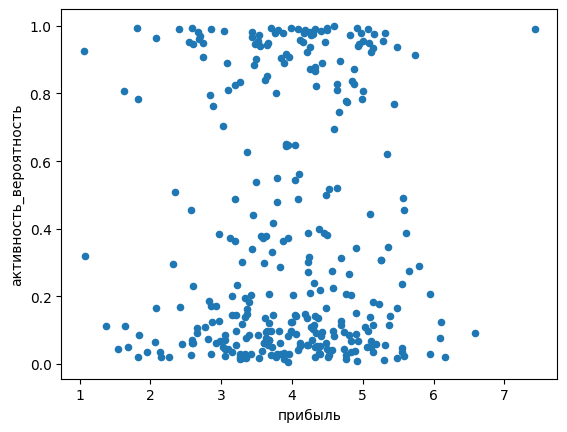

In [56]:
X_test.plot(kind='scatter', x='прибыль', y='активность_вероятность')
plt.show();

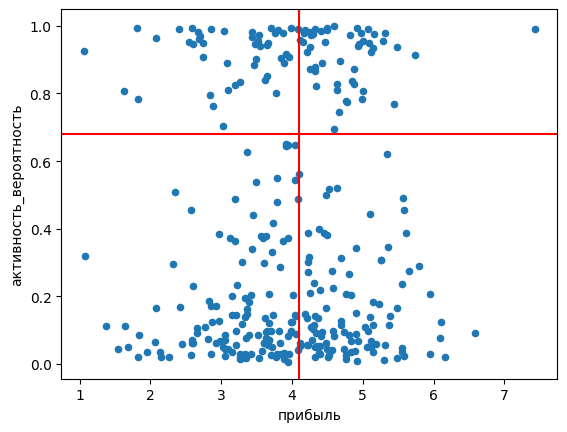

In [57]:
X_test.plot(kind='scatter', x='прибыль', y='активность_вероятность')
plt.axvline(x=4.1, color='red')
plt.axhline(y=0.68, color='red')
plt.show();

И так, проведём сегментацию. А именно возьмём сегмент пользователей, у которых с большой вероятностью снизится активность, но при этом они делают большую прибыль. Таким образом выделим пользователей с прибылью больше 4.1 и 0.68, это мы увидили из графика, нашли такие значения. И рассмотрим данный сегмент.

In [58]:
segment = X_test.query('прибыль > 4.1 & активность_вероятность > 0.68')
display(segment.info())
display(segment.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 152 to 367
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          50 non-null     object 
 1   разрешение_сообщать                  50 non-null     object 
 2   маркет_актив_6_мес                   50 non-null     float64
 3   маркет_актив_тек_мес                 50 non-null     int64  
 4   длительность                         50 non-null     int64  
 5   акционные_покупки                    50 non-null     float64
 6   популярная_категория                 50 non-null     object 
 7   средний_просмотр_категорий_за_визит  50 non-null     int64  
 8   неоплаченные_продукты_штук_квартал   50 non-null     int64  
 9   ошибка_сервиса                       50 non-null     int64  
 10  страниц_за_визит                     50 non-null     int64  
 11  минуты_предыдущий_месяц        

None

,тип_сервиса,разрешение_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_вероятность,активность_предикт,прибыль
152,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,4993.0,6604.0,6758.7,0.784330,1,4.99
495,премиум,да,4.3,4,1041,0.99,Кухонная посуда,4,1,6,6,9,14,4880.0,5339.0,5866.8,0.894970,1,4.68
27,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,8,9,4715.0,5253.5,5633.1,0.986979,1,4.18
103,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,11,10,4963.0,4045.0,4206.2,0.977937,1,5.31
322,премиум,да,4.0,4,820,0.22,Косметика и аксесуары,1,4,8,6,7,8,4670.0,5379.5,6034.7,0.971982,1,4.27


стандарт    0.64
премиум     0.36
Name: тип_сервиса, dtype: float64


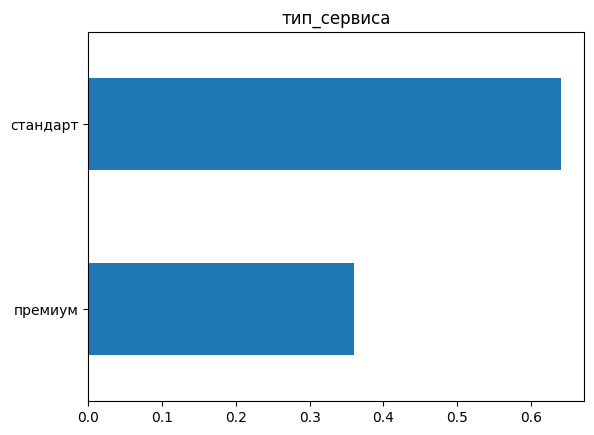

да     0.82
нет    0.18
Name: разрешение_сообщать, dtype: float64


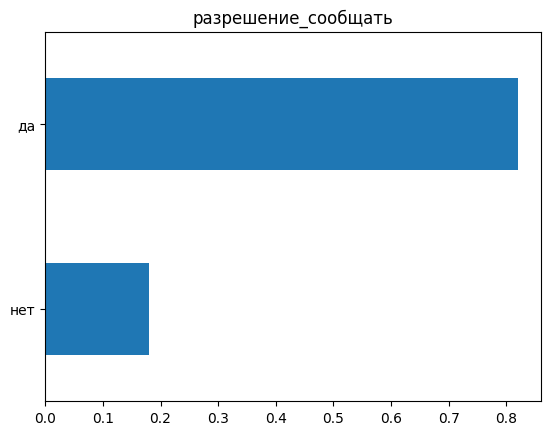

Домашний текстиль                       0.30
Товары для детей                        0.28
Косметика и аксесуары                   0.22
Кухонная посуда                         0.10
Техника для красоты и здоровья          0.06
Мелкая бытовая техника и электроника    0.04
Name: популярная_категория, dtype: float64


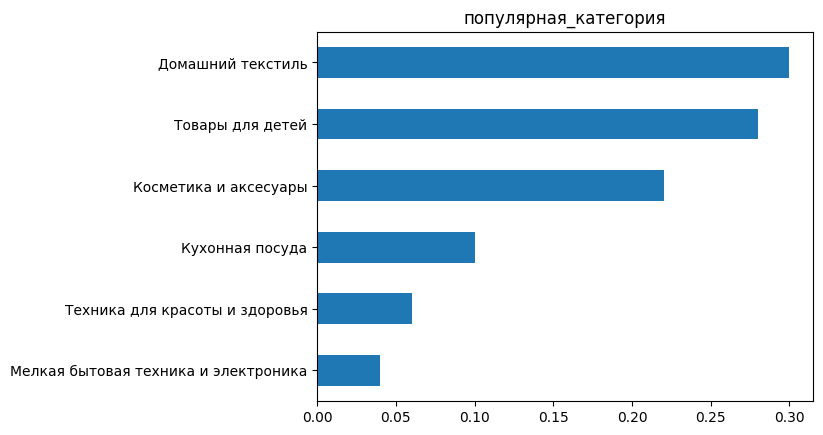

In [59]:
for i in cat_col_market:
    if i != 'активность':
        print(segment[i].value_counts(normalize=True, ascending=False))
        segment[i].value_counts(normalize=True, ascending=True).plot(kind='barh')
        plt.title(i)
        plt.show();

маркет_актив_6_мес 
 count    50.000000
mean      3.376000
std       1.153444
min       0.900000
25%       2.450000
50%       3.500000
75%       4.000000
max       5.600000
Name: маркет_актив_6_мес, dtype: float64


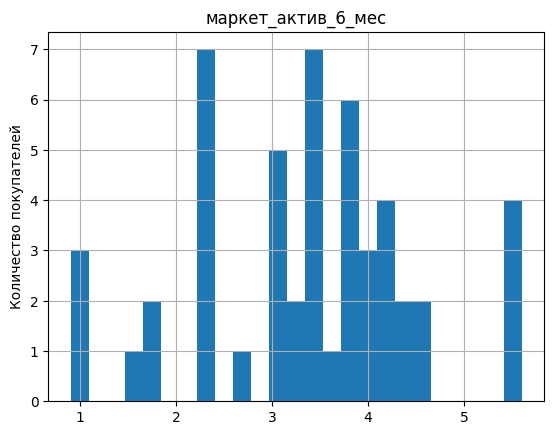

маркет_актив_тек_мес 
 count    50.00000
mean      4.04000
std       0.72731
min       3.00000
25%       4.00000
50%       4.00000
75%       5.00000
max       5.00000
Name: маркет_актив_тек_мес, dtype: float64


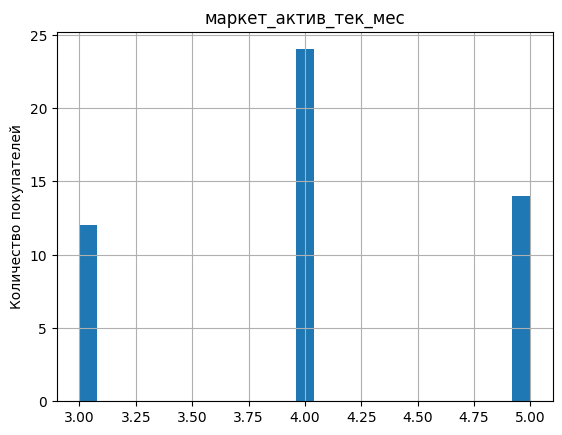

длительность 
 count      50.000000
mean      642.720000
std       244.515601
min       152.000000
25%       451.250000
50%       696.500000
75%       813.500000
max      1057.000000
Name: длительность, dtype: float64


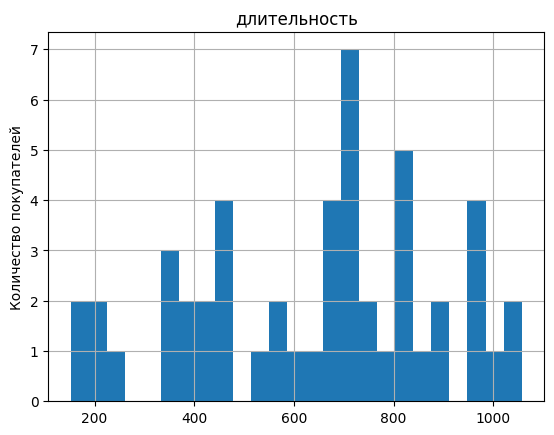

акционные_покупки 
 count    50.000000
mean      0.555800
std       0.318998
min       0.140000
25%       0.300000
50%       0.350000
75%       0.930000
max       0.990000
Name: акционные_покупки, dtype: float64


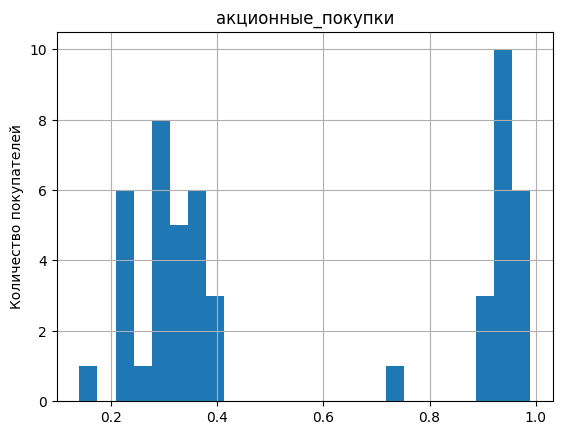

средний_просмотр_категорий_за_визит 
 count    50.000000
mean      2.820000
std       1.137308
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64


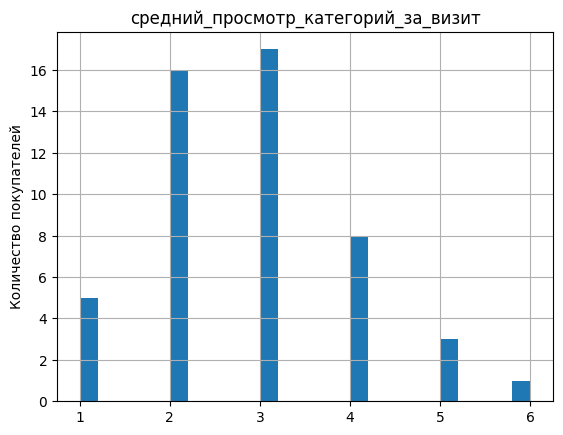

неоплаченные_продукты_штук_квартал 
 count    50.000000
mean      3.460000
std       2.002142
min       0.000000
25%       2.000000
50%       3.000000
75%       5.000000
max       8.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


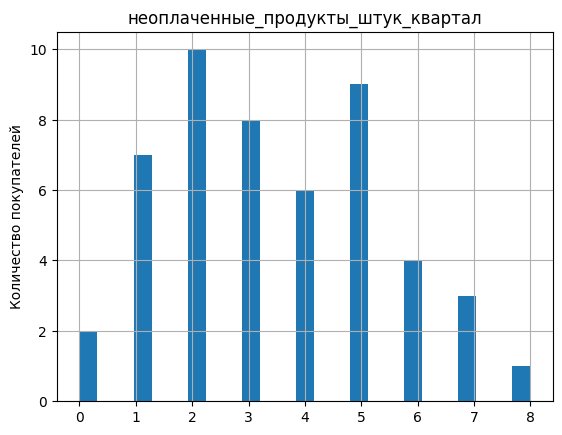

ошибка_сервиса 
 count    50.000000
mean      3.960000
std       1.999592
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       8.000000
Name: ошибка_сервиса, dtype: float64


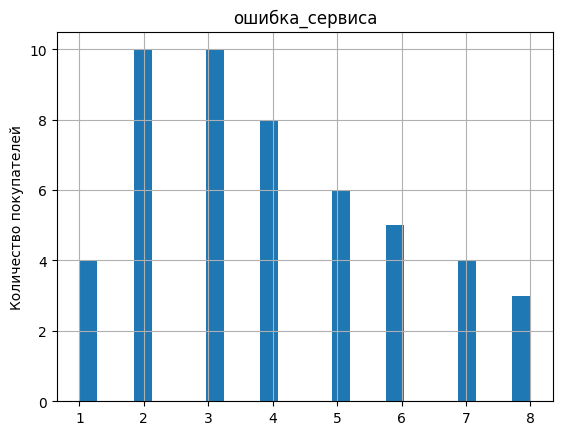

страниц_за_визит 
 count    50.000000
mean      4.280000
std       1.702819
min       1.000000
25%       3.000000
50%       4.000000
75%       6.000000
max       9.000000
Name: страниц_за_визит, dtype: float64


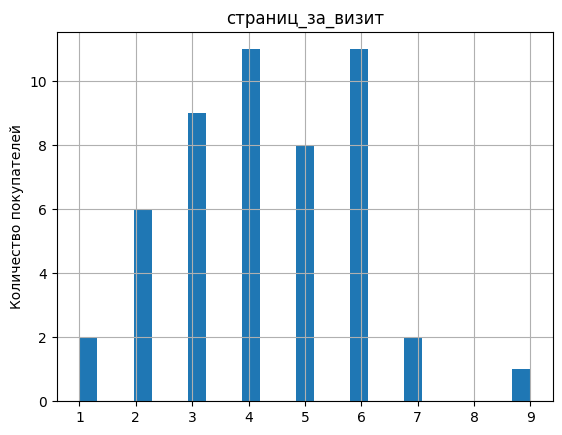

In [60]:
for i in num_col_market:
    print(i, '\n', segment[i].describe())
    segment[i].hist(bins=25)
    plt.ylabel('Количество покупателей')
    plt.title(i)
    plt.show();

Итак, просмотрев графики по признакам данного сегмента, можно предположить следующее: почти все пользователи данного сегмента - покупают так или иначе товары по акциям (19 человек вообще заказали почти 100% товаров по акциям). У данного сегмента достаточно высокая медиана по неоплаченным продуктам в корзине - 4. У 8 человек это значение больше или равно 6. Кроме того, данные пользователи имеют медиану просмотра категорий за визит на уровне 3. А страниц за визит - 4. То есть это скорее всего достаточно осознанный поиск определенных товаров. Так же самые популярные категории - Домашний текстиль, товары для детей, косметика и аксесуары, кухонная посуда - это почти 90% пользователей. То есть категории - не техника. Товары попадающие в данные категории - в большинстве нужны здесь и сейчас, никто не будет ждать месяцами скидок. Поэтому скорее всего данные пользователи искали конкретные товары, затем добавляли в корзину, искали в других местах даныне товары и находили дешевле, заказывали там, либо ждали акции и не дожидались. Поэтому, моё предложение такое: сделать систему персональных скидок, например, для премиум пользователей. При добавлении в корзину, если не покупают сразу товар, то делать предложение скидки.

*В любом случае сравним с контр-сегментом. Его выберем из противоположном группы покупателей (большая прибыль и прежний уровень активности)*

In [61]:
countersegment = X_test.query('прибыль > 4.1 & активность_вероятность < 0.32')
display(countersegment.info())
display(countersegment.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 812 to 884
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          86 non-null     object 
 1   разрешение_сообщать                  86 non-null     object 
 2   маркет_актив_6_мес                   86 non-null     float64
 3   маркет_актив_тек_мес                 86 non-null     int64  
 4   длительность                         86 non-null     int64  
 5   акционные_покупки                    86 non-null     float64
 6   популярная_категория                 86 non-null     object 
 7   средний_просмотр_категорий_за_визит  86 non-null     int64  
 8   неоплаченные_продукты_штук_квартал   86 non-null     int64  
 9   ошибка_сервиса                       86 non-null     int64  
 10  страниц_за_визит                     86 non-null     int64  
 11  минуты_предыдущий_месяц        

None

,тип_сервиса,разрешение_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_вероятность,активность_предикт,прибыль
812,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,4912.0,3973.0,3289.2,0.020580,0,6.16
958,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,4565.0,5444.0,6335.8,0.085220,0,4.81
1116,стандарт,да,4.9,4,739,0.17,Мелкая бытовая техника и электроника,5,1,4,4,18,15,5180.0,5505.5,5917.6,0.020967,0,4.33
1178,стандарт,нет,4.9,3,679,0.15,Техника для красоты и здоровья,4,1,1,14,12,19,5023.0,4668.0,5106.1,0.049042,0,5.11
536,стандарт,да,5.5,4,625,0.16,Косметика и аксесуары,3,3,7,5,13,14,5326.0,5150.5,5128.4,0.135787,0,4.37


стандарт    0.767442
премиум     0.232558
Name: тип_сервиса, dtype: float64


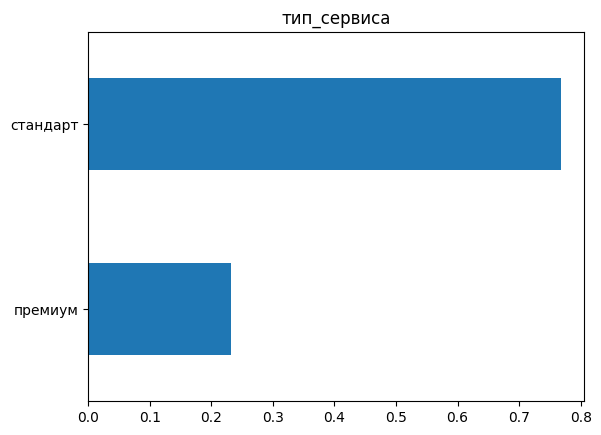

да     0.709302
нет    0.290698
Name: разрешение_сообщать, dtype: float64


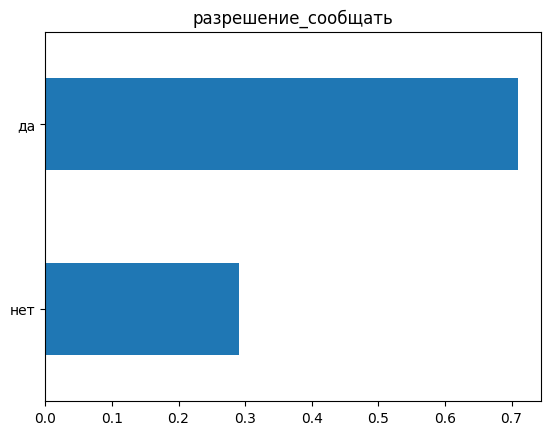

Техника для красоты и здоровья          0.197674
Домашний текстиль                       0.197674
Товары для детей                        0.197674
Мелкая бытовая техника и электроника    0.162791
Косметика и аксесуары                   0.127907
Кухонная посуда                         0.116279
Name: популярная_категория, dtype: float64


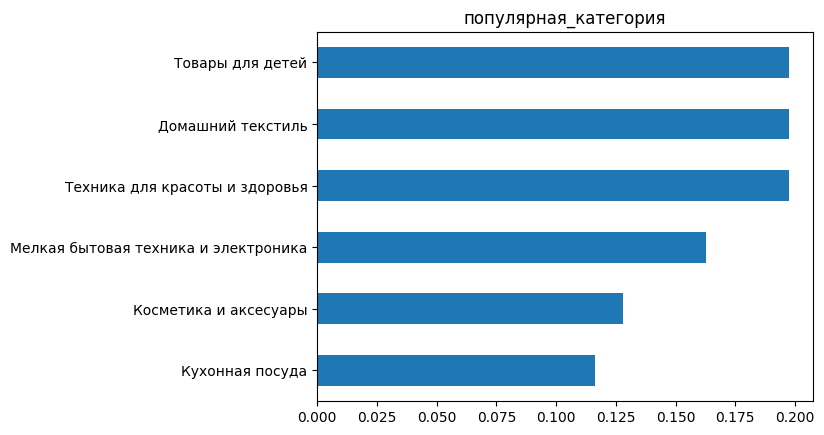

In [62]:
for i in ('тип_сервиса', 'разрешение_сообщать', 'популярная_категория'):
    print(countersegment[i].value_counts(normalize=True, ascending=False))
    countersegment[i].value_counts(normalize=True, ascending=True).plot(kind='barh')
    plt.title(i)
    plt.show();

маркет_актив_6_мес 
 count    86.000000
mean      4.575581
std       0.735317
min       3.000000
25%       4.100000
50%       4.500000
75%       5.175000
max       6.300000
Name: маркет_актив_6_мес, dtype: float64


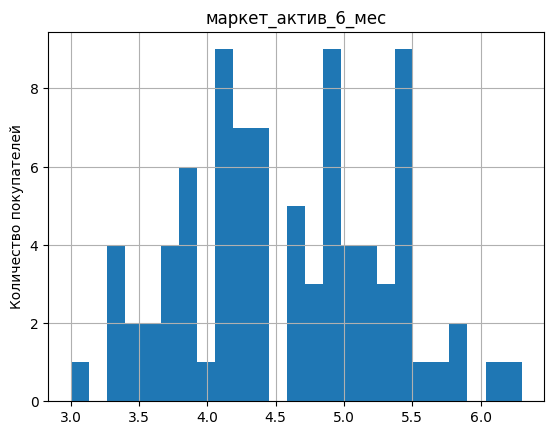

маркет_актив_тек_мес 
 count    86.000000
mean      3.953488
std       0.630723
min       3.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: маркет_актив_тек_мес, dtype: float64


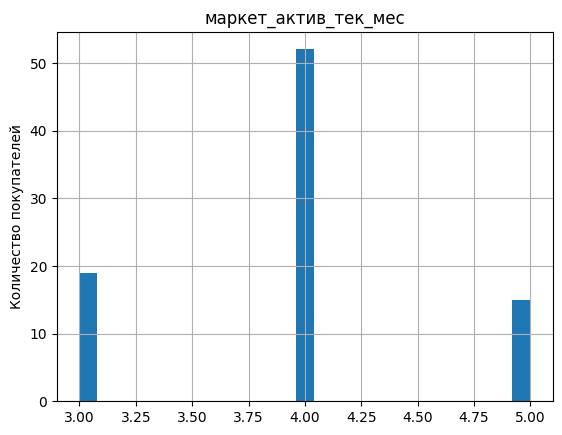

длительность 
 count      86.000000
mean      593.406977
std       231.951941
min       131.000000
25%       425.000000
50%       587.500000
75%       783.000000
max      1057.000000
Name: длительность, dtype: float64


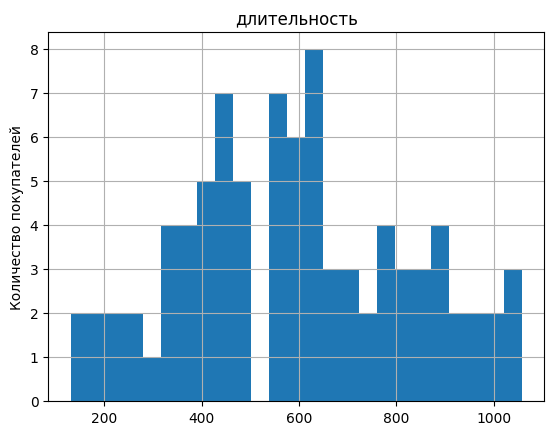

акционные_покупки 
 count    86.000000
mean      0.223140
std       0.127402
min       0.110000
25%       0.150000
50%       0.200000
75%       0.250000
max       0.940000
Name: акционные_покупки, dtype: float64


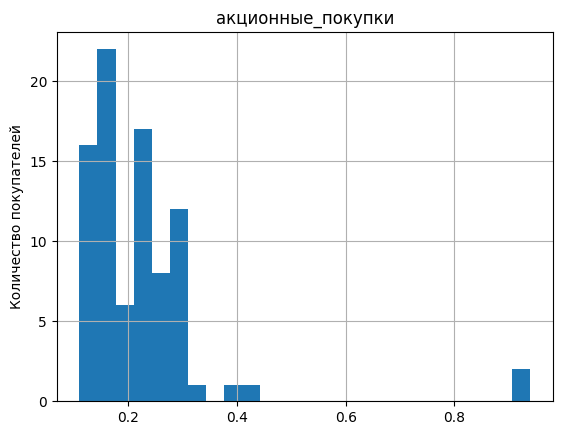

средний_просмотр_категорий_за_визит 
 count    86.000000
mean      3.906977
std       1.325123
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64


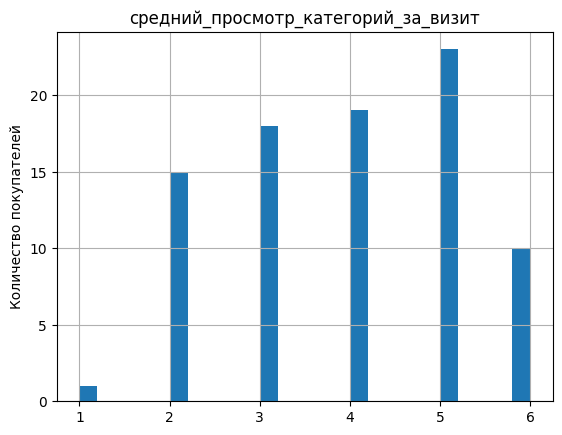

неоплаченные_продукты_штук_квартал 
 count    86.000000
mean      2.046512
std       1.345205
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


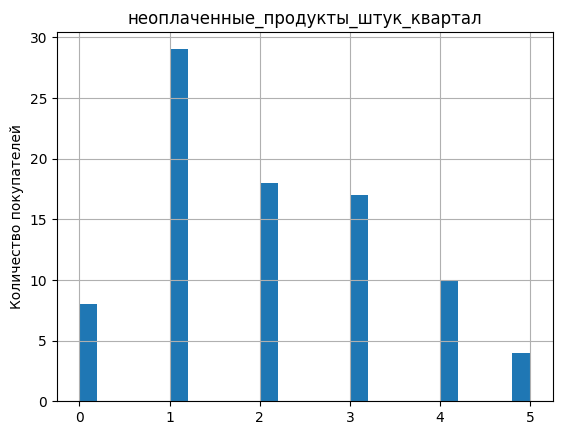

ошибка_сервиса 
 count    86.000000
mean      4.453488
std       2.038783
min       0.000000
25%       3.000000
50%       4.000000
75%       6.000000
max       9.000000
Name: ошибка_сервиса, dtype: float64


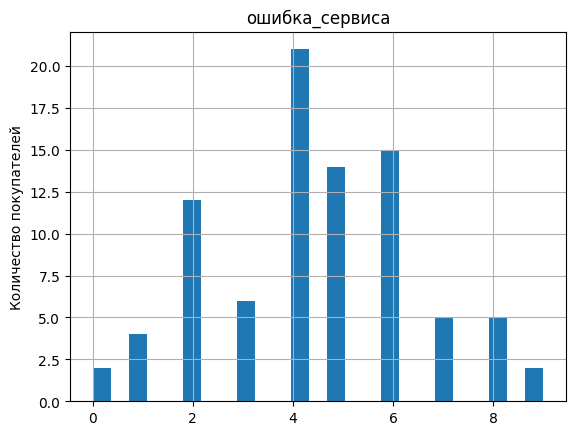

страниц_за_визит 
 count    86.000000
mean      9.988372
std       2.964473
min       4.000000
25%       8.000000
50%      10.000000
75%      12.000000
max      17.000000
Name: страниц_за_визит, dtype: float64


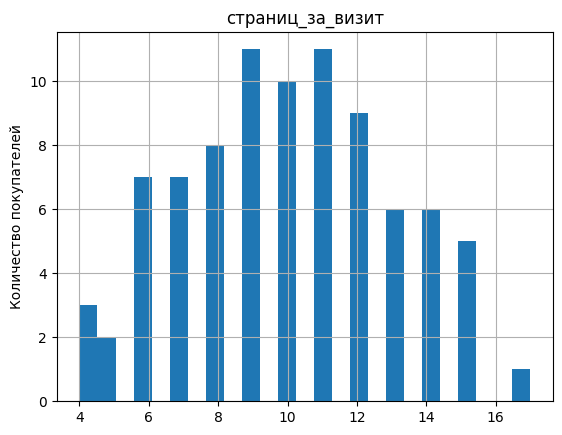

In [63]:
for i in num_col_market:
    print(i, '\n', countersegment[i].describe())
    countersegment[i].hist(bins=25)
    plt.ylabel('Количество покупателей')
    plt.title(i)
    plt.show();

*Действительно, у контрсегмента видим меньшее число акционных товаров (медиана 0.2 против 0.35), больше маркетинговая активность за 6 месяцев (медиана 4.5 против 3.5), категорий за визит больше (медиана 4 против 3), а так же меньше неоплаченных вещей (медиана 2 против 3). Самое интересное, что страниц за визит контрсегмент посещает гораздо больше (медиана 10 против 4). Что же по популярным категориям, то распределение стало ровнее. Таким образом, предложенные ранее рекомендации лишь подтверждаются.*

## Общий вывод

Итак. Мы выполнили поставленную задачу интернет-магазином "В один клик". Нам было необходимо разработать модель, которая по входным признакам находила целевой - предсказывала снизиться ли покупательская активность или нет.

Таким образом, первым шагом загрузили 4 датафрейма с данными о поведении покупателей, об общей выручке с покупателя, о проведённом времени покупателем на сайте, о среднемесячной выручке с покупателя за 3 последних месяца. Далее провели предобработку данных: переименовали столбцы, а так же переименовали некоторые значения в категориальных признаках, дубликатов и пропусков не было. Следующим шагом провели исследовательский анализ данных, в большинстве своём данные имеют нормальное распределение. Был выброс, который устранили. Затем объединили 3 датафрейма (без среднемесячной прибыли), далее отсеяли покупателей, которые за хотя бы один месяц ничего не покупали. После этого провели корреляционный анализ, чтобы устранить, если имеется, мультиколинеарность, её в данных не оказалось. 

Потом создали пайплайн, чтобы найти лучшую модель. Перебирали из 4: Линейная регрессия, метод k-ближайших соседей, дерево решений и метод опорных векторов. Кроме того задали для них перебор гиперпараметров. Проводили поиск лучшей модели так: считали roc_auc для разных моделей и разных параметров, а затем выбрали лучшую модель - как модель с самым высоким значением roc_auc. Перебирали с помощью RandomizedSearchCV, то есть перебор рандомный. В ходе поиска лучшей МО выявили, что лучшей является метод опорных векторов с парметрами: kernel = rbf, C = 0.1. ROC-AUC для тренировочной выборки стала 0.9, для тестовой выборки 0.92. 

Далее выполнили анализ важности признаков. Больше всего влияют на то, останется прежним уровень активности или упадёт, следующие признаки (4 из 6 "топовых" признака): страницы за визит, средний просмотр категорий за визит, минуты в текущем месяце, минуты в предыдущем месяце. Что интересно, с уменьшением значений данных признаков уменьшается вероятность предсказать активность на том же уровне. Но более интересно с признаками: неоплаченные продукты в корзине за квартал и акционные покупки. С увеличением данных значений падает вероятность предсказать активность на том же уровне. Это можно объяснить тем, что покупатели откладывают товары, пытаясь купить их лишь в акции. Соответственно такой признак сильно влияет на то, что снижается покупательская активность таких покупателей. Ещё один интересный признак - это маркетинговая активность в последние 6 месяцев. Чем больше маркетинговых взаимодействий, тем меньше вероятность предсказать снижение покупательской активности. Меньше всего из признаков влияет выручка в текущем месяце, практически никакого влияния.

Затем проведём сегментацию покупателей, чтобы лучше описать отдельную группу покупателей. Выделили сегмент, который приносит большую прибыль, но при этом по прогнозу лучшей модели снизит свою активность. По признакам данного сегмента, можно предположить, что почти все пользователи данного сегмента - покупают так или иначе товары по акциям (относительно большой процент покупок - по акциям). Кроме того, у данного сегмента достаточно высокая медиана по неоплаченным продуктам в корзине - 4. У 8 человек это значение больше или равно 6. Также данные пользователи имеют медиану просмотра категорий за визит на уровне 3. А страниц за визит - 4. То есть, это скорее всего достаточно осознанный поиск определенных товаров. Так же самые популярные категории - Домашний текстиль, товары для детей, косметика и аксесуары, кухонная посуда - это почти 90% пользователей. То есть категории - не техника. Товары попадающие в данные категории - в большинстве нужны здесь и сейчас, никто не будет ждать месяцами скидок. Поэтому скорее всего данные пользователи искали конкретные товары, затем добавляли в корзину, искали в других местах даныне товары и находили дешевле, заказывали там, либо ждали акции и не дожидались.

Более того, сравнив контрсегмент и сегмент, у контрсегмента видим меньшее число акционных товаров (медиана 0.2 против 0.35), больше маркетинговая активность за 6 месяцев (медиана 4.5 против 3.5), категорий за визит больше (медиана 4 против 3), а так же меньше неоплаченных вещей (медиана 2 против 3). Самое интересное, что страниц за визит контрсегмент посещает гораздо больше (медиана 10 против 4). Что же по популярным категориям, то распределение стало ровнее.

По проведенному анализу сегмента (и контрсегмента) могу предложить следующее: сделать систему персональных скидок, например, для премиум пользователей, при добавлении в корзину, если не покупают сразу товар, то делать предложение скидки на товары в корзине. Таково мое предложение по выбранному сегменту.